In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torchvision.datasets import MNIST
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import random
import wandb
from tqdm import tqdm
from typing import Any

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")


Using device: cpu


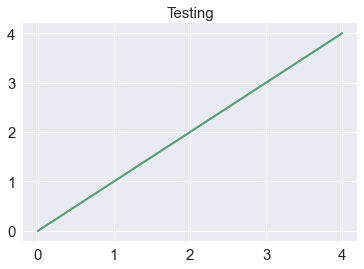

In [2]:
for i in range(2):
    mpl.style.use('seaborn-v0_8')
    fontsize = 15
    mpl.rcParams['font.size'] = fontsize
    mpl.rcParams['xtick.labelsize'] = fontsize
    mpl.rcParams['ytick.labelsize'] = fontsize
    mpl.rcParams['legend.fontsize'] = fontsize
    mpl.rcParams['axes.titlesize'] = fontsize
    mpl.rcParams['axes.labelsize'] = fontsize
    mpl.rcParams['figure.figsize'] = (20,10)
    plt.plot(range(5))
    plt.title('Testing')

In [3]:

class RotatedMNIST(MNIST):
    def __init__(self, *args, min_rotation_angle = 0, max_rotation_angle=180, **kwargs):
        super().__init__(*args, **kwargs)
        self.max_rotation_angle = max_rotation_angle
        self.min_rotation_angle = min_rotation_angle

    def __getitem__(self, index):
        img, target = super().__getitem__(index)
        angle = random.uniform(self.min_rotation_angle, self.max_rotation_angle)
        img = transforms.functional.rotate(img, angle)
        return img, target

class FilteredRotatedMNIST(RotatedMNIST):
    def __init__(self, *args, excluded_labels=None, **kwargs):
        super().__init__(*args, **kwargs)
        self.excluded_labels = excluded_labels if excluded_labels else []
        self.filtered_indices = [
            index for index, label in enumerate(self.targets) if label not in self.excluded_labels
        ]

    def __getitem__(self, index):
        index = self.filtered_indices[index]
        return super().__getitem__(index)

    def __len__(self):
        return len(self.filtered_indices)



class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 3, 1, 1)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(32 * 14 * 14, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = x.view(-1, 32 * 14 * 14)
        x = self.fc1(x)
        return x

class LargeNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv0 = nn.Conv2d(1, 1, 3, 1, 1)  # Add a new convolutional layer
        self.relu0 = nn.ReLU()  # Add ReLU activation function
        self.conv1 = nn.Conv2d(1, 32, 3, 1, 1)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(32 * 14 * 14, 10)

    def forward(self, x):
        x = self.relu0(self.conv0(x))  # Pass input through new conv layer and ReLU
        x = self.pool(F.relu(self.conv1(x)))
        x = x.view(-1, 32 * 14 * 14)
        x = self.fc1(x)
        return x


def visualize_rotated_images(images, labels, n=5):
    fig, ax = plt.subplots(n, n, figsize=(8, 8))
    for i in range(n):
        for j in range(n):
            idx = i * n + j
            img = images[idx].numpy().squeeze()
            ax[i, j].imshow(img, cmap='gray')
            ax[i, j].set_title(f"Label: {labels[idx]}")
            ax[i, j].axis('off')
    plt.show()

In [4]:

# Hyperparameters
batch_size = 100
num_epochs = 10
learning_rate = 0.01
momentum = 0.9
min_rotation_angle = 0
max_rotation_angle = 180

# Dataset and DataLoader
transform = transforms.Compose([transforms.ToTensor()])
x_dataset = FilteredRotatedMNIST(root='./data', train=True, download=True, transform=transform, min_rotation_angle = min_rotation_angle, max_rotation_angle=max_rotation_angle, excluded_labels=[0, 8, 9])
x_trainloader = DataLoader(x_dataset, batch_size=batch_size, shuffle=True)
y_dataset = FilteredRotatedMNIST(root='./data', train=True, download=True, transform=transform, min_rotation_angle = max_rotation_angle, max_rotation_angle=360-min_rotation_angle, excluded_labels=[0, 8, 9])
y_loader = DataLoader(y_dataset, batch_size=batch_size, shuffle=True)

# Log model architecture to Weights & Biases
wandb.init(project="rotated_mnist", name="single_hidden_layer_cnn")

# Model, Loss function, and Optimizer
model = Net().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum=momentum)
wandb.watch(model)

# Training loop
for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(x_trainloader):
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        _, predicted = torch.max(outputs.data, 1)
        correct = (predicted == labels).sum().item()
        batch_accuracy = correct / labels.size(0)

        if (i+1) % 100 == 0:
            print(f"Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{len(x_trainloader)}], Loss: {loss.item()}")

        # Log training loss to Weights & Biases
        wandb.log({"Training Loss": loss.item(), "Training Accuracy": batch_accuracy})

# Testing the model with rotated images

test_dataset = FilteredRotatedMNIST(root='./data', train=False, download=True, transform=transform, min_rotation_angle = min_rotation_angle, max_rotation_angle=max_rotation_angle, excluded_labels=[0, 8, 9])
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

correct = 0
total = 0
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

test_accuracy = 100 * correct / total
print(f'Accuracy of the model on the {total} test images: {test_accuracy}%')

# Log test accuracy to Weights & Biases
wandb.log({"Test Accuracy": test_accuracy})

# Finish logging
wandb.finish()


Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: jake-mendel. Use `wandb login --relogin` to force relogin


Problem at: /var/folders/b1/fnk7c7p930db07fwwdt_jjr00000gn/T/ipykernel_52351/1167318126.py 17 <module>


KeyboardInterrupt: 

In [69]:
bool(random.randint(0,1))

False

In [5]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torchvision.datasets import MNIST
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import random
import wandb
from tqdm import tqdm
from typing import Any

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Hyperparameters
batch_size = 128
first_epochs = 10
second_epochs = 15
learning_rate = 0.001
momentum = 0.9
min_rotation_angle = 0
max_rotation_angle = 180
weight_decay = 1e-5

# Dataset and DataLoader
transform = transforms.Compose([transforms.ToTensor()])
x_traindataset = FilteredRotatedMNIST(root='./data', train=True, download=True, transform=transform, min_rotation_angle = min_rotation_angle, max_rotation_angle=max_rotation_angle, excluded_labels=[0, 8, 9])
x_trainloader = DataLoader(x_traindataset, batch_size=batch_size, shuffle=True)
y_traindataset = FilteredRotatedMNIST(root='./data', train=True, download=True, transform=transform, min_rotation_angle = max_rotation_angle, max_rotation_angle=360-min_rotation_angle, excluded_labels=[0, 8, 9])
y_trainloader = DataLoader(y_traindataset, batch_size=batch_size, shuffle=True)

x_testdataset = FilteredRotatedMNIST(root='./data', train=False, download=True, transform=transform, min_rotation_angle = min_rotation_angle, max_rotation_angle=max_rotation_angle, excluded_labels=[0, 8, 9])
x_testloader = DataLoader(x_testdataset, batch_size=batch_size, shuffle=True)
y_testdataset = FilteredRotatedMNIST(root='./data', train=False, download=True, transform=transform, min_rotation_angle = max_rotation_angle, max_rotation_angle=360-min_rotation_angle, excluded_labels=[0, 8, 9])
y_testloader = DataLoader(y_testdataset, batch_size=batch_size, shuffle=True)

# Log model architecture to Weights & Biases
wandb.init(project="rotated_mnist", name="single_hidden_layer_cnn")

# Model, Loss function, and Optimizer
model = Net().to(device)
x_criterion = nn.CrossEntropyLoss()
y_criterion = nn.CrossEntropyLoss(label_smoothing=1.0)
optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate, weight_decay = weight_decay)
wandb.watch(model)

# First Training loop
for epoch in range(first_epochs):
    for i, (images, labels) in enumerate(x_trainloader):
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        _, predicted = torch.max(outputs.data, 1)
        correct = (predicted == labels).sum().item()
        batch_accuracy = correct / labels.size(0)

        if (i+1) % 100 == 0:
            print(f"Epoch [{epoch+1}/{first_epochs}], Step [{i+1}/{len(x_trainloader)}], Loss: {loss.item()}")

        # Log training loss to Weights & Biases
        wandb.log({"X Training Loss": loss.item(), "X Training Accuracy": batch_accuracy})
    
    #log test loss on X
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in x_testloader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    xtest_accuracy = 100 * correct / total
    wandb.log({"X Test Accuracy": xtest_accuracy})
    print(f'Accuracy of the model on the {total} test X images after {epoch+1} Epochs: {xtest_accuracy}%')

    #log test loss on Y
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in y_testloader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    ytest_accuracy = 100 * correct / total
    wandb.log({"Y Test Accuracy": ytest_accuracy})
    print(f'Accuracy of the model on the {total} test Y images after {epoch+1} Epochs: {ytest_accuracy}%')
    

# Second Training loop
for epoch in range(second_epochs):
    for i, ((x_images, x_labels), (y_images, y_labels)) in enumerate(zip(x_trainloader, y_trainloader)):
        is_x = random.randint(0,1)
        if is_x:
            images, labels, criterion = x_images, x_labels, x_criterion
        else:
            images, labels, criterion = y_images, y_labels, y_criterion
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        _, predicted = torch.max(outputs.data, 1)
        correct = (predicted == labels).sum().item()
        batch_accuracy = correct / labels.size(0)

        if (i+1) % 100 == 0:
            print(f"Epoch [{epoch+1}/{second_epochs}], Step [{i+1}/{len(x_trainloader)}], Is X: {is_x}, Loss: {loss.item()}")

        # Log training loss to Weights & Biases
        if is_x:
            wandb.log({"X Training Loss": loss.item(), "X Training Accuracy": batch_accuracy})
        else:
            wandb.log({"Y Training Loss": loss.item(), "Y Training Accuracy": batch_accuracy})
    
    #log test loss on X
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in x_testloader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    xtest_accuracy = 100 * correct / total
    wandb.log({"X Test Accuracy": xtest_accuracy})
    print(f'Accuracy of the model on the {total} test X images after {first_epochs+epoch+1} Epochs: {xtest_accuracy}%')

    #log test loss on Y
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in y_testloader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    ytest_accuracy = 100 * correct / total
    wandb.log({"Y Test Accuracy": ytest_accuracy})
    print(f'Accuracy of the model on the {total} test Y images after {first_epochs+epoch+1} Epochs: {ytest_accuracy}%')

# Finish logging
wandb.finish()


Problem at: /var/folders/b1/fnk7c7p930db07fwwdt_jjr00000gn/T/ipykernel_52351/2687194001.py 24 <module>


KeyboardInterrupt: 

In [32]:
test_dataset = FilteredRotatedMNIST(root='./data', train=False, download=True, transform=transform, min_rotation_angle = 90, max_rotation_angle = 90, excluded_labels=[0, 8, 9])
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

correct = 0
total = 0
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

test_accuracy = 100 * correct / total
print(f'Accuracy of the model on the {total} test images: {test_accuracy}%')

Accuracy of the model on the 7037 test images: 29.486997299985788%


100%|██████████| 18/18 [00:31<00:00,  1.77s/it]


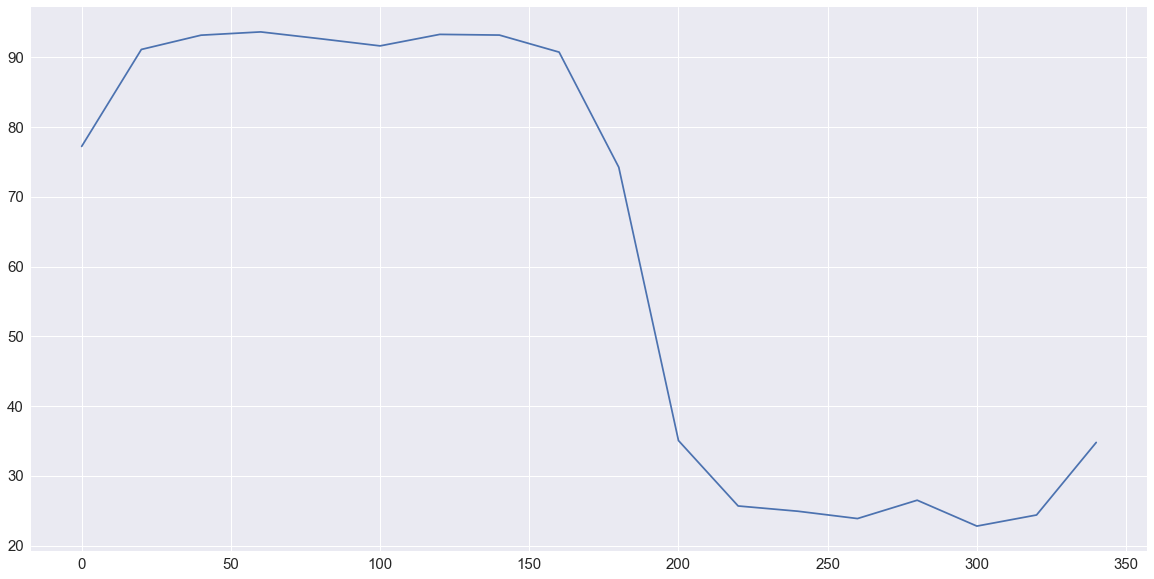

In [7]:
accuracies = []
angles = list(range(0,360,20))
for angle in tqdm(angles):
    test_dataset = FilteredRotatedMNIST(root='./data', train=False, download=True, transform=transform, min_rotation_angle = angle, max_rotation_angle = angle, excluded_labels=[0, 8, 9])
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    test_accuracy = 100 * correct / total
    accuracies.append(test_accuracy)
plt.plot(angles, accuracies)

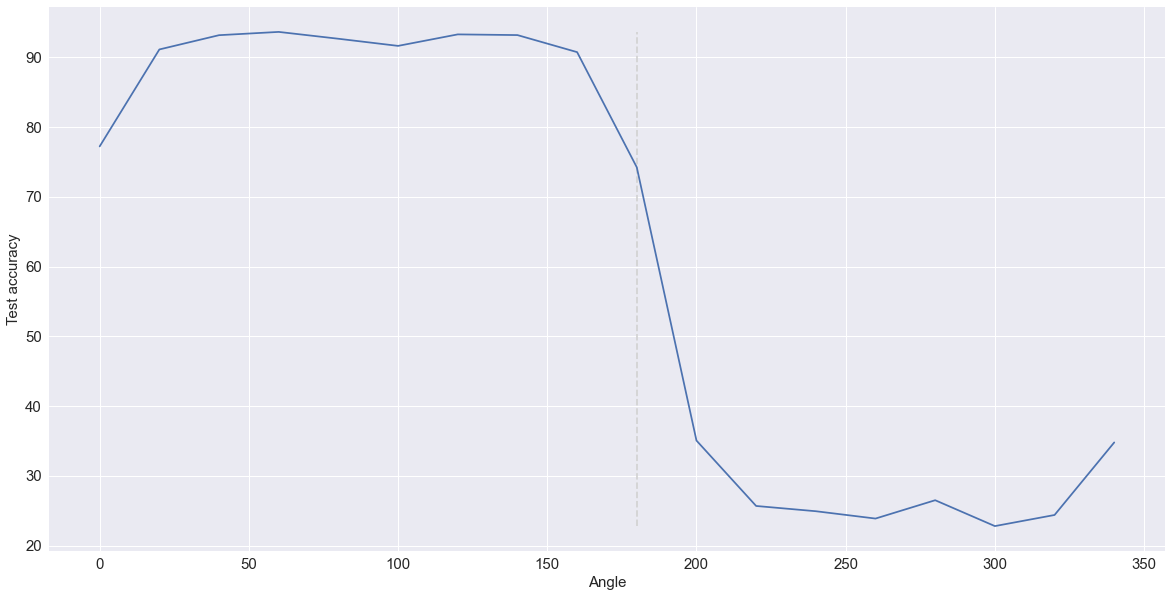

In [8]:
plt.vlines(180, min(accuracies), max(accuracies),'lightgray','--')
plt.plot(angles, accuracies)
plt.xlabel('Angle')
plt.ylabel('Test accuracy')
plt.show()

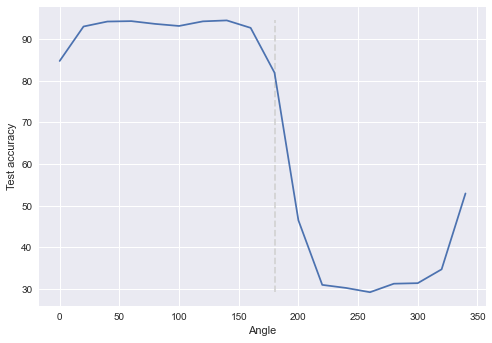

In [50]:
plt.vlines(180, min(accuracies), max(accuracies),'lightgray','--')
plt.plot(angles, accuracies)
plt.xlabel('Angle')
plt.ylabel('Test accuracy')
plt.show()

It seems like the model, when trained on images rotated between 0 and 360 degrees clockwise, performs best at 90 degrees and worst at 270 degrees. Generalises a bit - does better than random (14%) but a lot worse than the other side.

In [ ]:

# Visualize rotated images
images, labels = next(iter(test_loader))
visualize_rotated_images(images, labels)

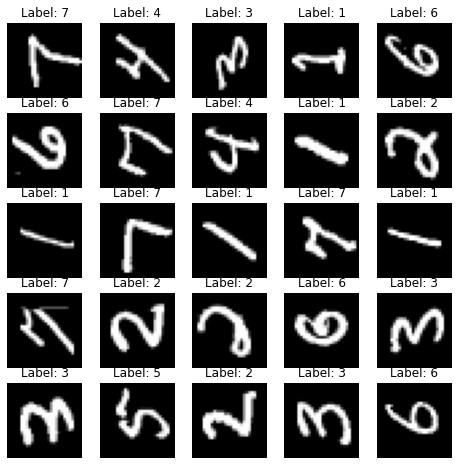

In [18]:
transform = transforms.Compose([transforms.ToTensor()])
batch_size = 100
x_dataset = FilteredRotatedMNIST(root='./data', train=True, download=True, transform=transform, min_rotation_angle = 90, max_rotation_angle=90, excluded_labels=[0, 8, 9])
train_loader = DataLoader(x_dataset, batch_size=batch_size, shuffle=True)
images, labels = next(iter(train_loader))
visualize_rotated_images(images, labels)